# Homework 1

## FINM 37500 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Context

For use in these problems, consider the data below, discussed in Veronesi's *Fixed Income Securities* Chapters 9, 10.
* interest-rate tree
* current term structure

In [40]:
import numpy as np
import pandas as pd
import math

In [41]:
rate_tree = pd.DataFrame({'0':[.0174,np.nan],'0.5':[.0339,.0095]})
rate_tree.columns.name = 'time $t$'
rate_tree.index.name = 'node'
rate_tree.style.format('{:.2%}',na_rep='')

time $t$,0,0.5
node,,
0,1.74%,3.39%
1,,0.95%


The "tree" is displayed as a pandas dataframe, so it does not list "up" and "down" for the rows but rather an index of nodes. The meaning should be clear.

In [42]:
term_struct = pd.DataFrame({'maturity':[.5,1,1.5],'price':[99.1338,97.8925,96.1462]})
term_struct['continuous ytm'] = -np.log(term_struct['price']/100) / term_struct['maturity']
term_struct.set_index('maturity',inplace=True)
term_struct.style.format({'price':'{:.4f}','continuous ytm':'{:.2%}'}).format_index('{:.1f}')

,price,continuous ytm
maturity,,
0.5,99.1338,1.74%
1.0,97.8925,2.13%
1.5,96.1462,2.62%


This is the current term-structure observed at $t=0$.

# 1. Pricing a Swap

### 1.1 
Calculate the tree of bond prices for the 2-period, $T=1$, bond.


In [43]:
P_0_2 = 97.8925 # Given in info above
print(f"At t=0 the price (given in the table above) is: {P_0_2}")

up_rate = 0.0339
P_1up_2 = math.exp(-up_rate * 0.5) * 100
print(f"At t=0.5 when rates have moved up the price is: {round(P_1up_2, 4)}")

down_rate = 0.0095
P_1down_2 = math.exp(-down_rate * 0.5) * 100
print(f"At t=0.5 when rates have moved down the price is: {round(P_1down_2, 4)}")

P_2upup = P_2updown = P_2downup = P_2downdown = 100
print(f"At t=1 we have hit the terminal nodes and all prices are: 100")


At t=0 the price (given in the table above) is: 97.8925
At t=0.5 when rates have moved up the price is: 98.3193
At t=0.5 when rates have moved down the price is: 99.5261
At t=1 we have hit the terminal nodes and all prices are: 100


Note that these prices align with the class discussion values.


### 1.2 
What is the risk-neutral probability of an upward movement of interest rates at $t=.5$?

We'll use this formula:

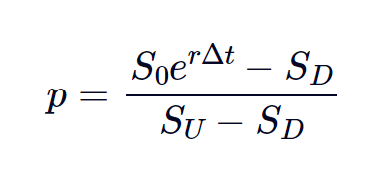

In [44]:
r0 = 0.0174
dt = 0.5
A = np.exp(r0 * dt)
pstar = (P_0_2 * A - P_1down_2)/(P_1up_2-P_1down_2)

print(f"The risk neutral probability of an upward movement is: {pstar}, or {round(pstar * 100, 2)}%")

The risk neutral probability of an upward movement is: 0.6448615964742744, or 64.49%


## The option contract

Consider a single-period swap that pays at time period 1 ($t=0.5$), the expiration payoff (and thus terminal value) is
* Payoff = $\frac{100}{2}(r_1 −c)$
* with $c=2\%$
* payments are semiannual

Take the viewpoint of a fixed-rate payer, floating rate receiver.

### 1.3 
What is the replicating trade using the two bonds (period 1 and period 2)?


In [45]:
# Following the class replication, changing payoff function
FACE = 100
r1 = np.array([.0339, .0095])
rK = 0.02
fud = FACE / 2 * (r1 - rK)

P1_2 = [98.3193, 99.5261]

beta = (fud[0] - fud[1]) / (P1_2[0] - P1_2[1])
alpha = (fud[0] - beta * P1_2[0])/FACE

position = pd.DataFrame(index=['1-period bond','2-period bond'],columns=['price','position','$ holding'],dtype=float)
position['price'] = term_struct.iloc[0:2,0].values
position['position'] = [alpha,beta]
position['$ holding'] = position['price'] * position['position']
position.loc['net','$ holding'] = position['$ holding'].sum()
position['price'] = position['price'].map('${:,.4f}'.format)
position['$ holding'] = position['$ holding'].map('${:,.4f}'.format)
position

,price,position,$ holding
1-period bond,$99.1338,1.000897,$99.2227
2-period bond,$97.8925,-1.010938,$-98.9632
net,$nan,NaN,$0.2595


### 1.4 
What is the price of the swap?

Based on the replicating tree above, we can see that the value of the swap is $0.2595

# 2. Using the Swap as the Underlying
As in the note, W.1, consider pricing the following interest-rate option,
* Payoff is $100\max(r_K-r_1,0)$
* strike is $r_K$ is 2\%
* expires at period 1, ($t=0.5$) 

Unlike the note, price it with the swap used as the underlying, not the two-period ($t=1$) bond. You will once again use the period-1 ($t=0.5$) bond as the cash account for the no-arbitrage pricing.

So instead of replicating the option with the two treasuries, now you're replicating/pricing it with a one-period bond and two-period swap.

### 2.1
Display the tree of swap prices.

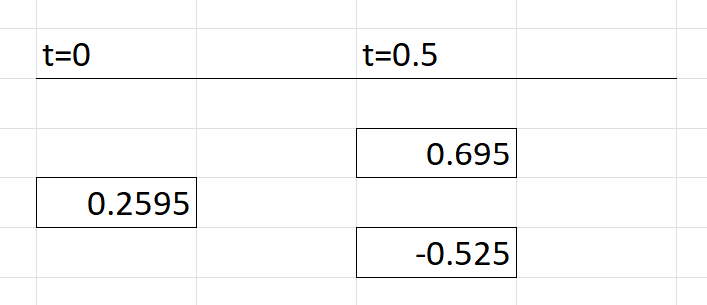

### 2.2
What is the risk-neutral probability of an upward movement at $t=.5$ implied by the underlying swap tree? 

Is this the same as the risk-neutral probability we found when the bond was used as the underlying?

In [46]:
r0 = 0.0174
dt = 0.5
A = np.exp(r0 * dt)

P_0 = 0.2595
P_1up = 0.695
P_1down = -0.525
pstar = (P_0 * A - P_1down)/(P_1up-P_1down)

print(f"The risk neutral probability of an upward movement is: {pstar}, or {round(pstar * 100, 2)}%")

The risk neutral probability of an upward movement is: 0.6448913928850879, or 64.49%


We note that this is the same risk-neutral probability we found with the bond.

### 2.3
What is the price of the rate option? Is it the same as we calculated in the note, W.1.?

In [47]:
FACE = 100
r0 = .0174
r1 = np.array([.0339, .0095])
rK = .02
fud = FACE * (rK-r1)
fud[fud<0] = 0

P1_2 = [0.695, -0.525]

beta = (fud[0] - fud[1]) / (P1_2[0] - P1_2[1])
alpha = (fud[0] - beta * P1_2[0])/FACE

position = pd.DataFrame(index=['1-period bond','2-period swap'],columns=['price','position','$ holding'],dtype=float)
position['price'] = [term_struct.iloc[0,0], P_0]
position['position'] = [alpha,beta]
position['$ holding'] = position['price'] * position['position']
position.loc['net','$ holding'] = position['$ holding'].sum()
position['price'] = position['price'].map('${:,.4f}'.format)
position['$ holding'] = position['$ holding'].map('${:,.4f}'.format)
position

,price,position,$ holding
1-period bond,$99.1338,0.005982,$0.5930
2-period swap,$0.2595,-0.860656,$-0.2233
net,$nan,NaN,$0.3696


This price is the same as we calculated in class: $0.3696

# 3. Pricing a Call on a Bond

Try using the same tree to price a call on the period-2 bond, (1-year), at period 1 (6-months).
* Payoff = $\max(P_{1|2}-K,0)$
* Strike = \$99.00

### 3.1 
What is the replicating trade using the two bonds (period 1 and period 2) as above? (That is, we are no longer using the swap as the underlying.)


In [48]:
FACE = 100
P1_2 = [98.3193, 99.5261]
K = 99
fud = [0, P1_2[1] - K]

beta = (fud[0] - fud[1]) / (P1_2[0] - P1_2[1])
alpha = (fud[0] - beta * P1_2[0])/FACE

position = pd.DataFrame(index=['1-period bond','2-period bond'],columns=['price','position','$ holding'],dtype=float)
position['price'] = term_struct.iloc[0:2,0].values
position['position'] = [alpha,beta]
position['$ holding'] = position['price'] * position['position']
position.loc['net','$ holding'] = position['$ holding'].sum()
position['price'] = position['price'].map('${:,.4f}'.format)
position['$ holding'] = position['$ holding'].map('${:,.4f}'.format)
position

,price,position,$ holding
1-period bond,$99.1338,-0.428619,$-42.4907
2-period bond,$97.8925,0.435946,$42.6759
net,$nan,NaN,$0.1852



### 3.2 
What is the price of the European call option? 
* expiring at $T=.5$ 
* written on the bond maturing in 2 periods, ($t=1$)

According to the replication above, the price is $0.1852

# 4 Two-Period Tree

Consider an expanded, **2 period** tree. (Two periods of uncertainty, so with the starting point, three periods total.)

In [49]:
new_col = pd.Series([.05,.0256,.0011],name='1')
rate_tree_multi = pd.concat([rate_tree,new_col],ignore_index=True,axis=1)
rate_tree_multi.columns = pd.Series(['0','0.5','1'],name='time $t$')
rate_tree_multi.index.name = 'node'
rate_tree_multi.style.format('{:.2%}',na_rep='')

time $t$,0,0.5,1
node,,,
0,1.74%,3.39%,5.00%
1,,0.95%,2.56%
2,,,0.11%


### 4.1

Calculate and show the tree of prices for the 3-period bond, $T=1.5$.

* $P_{0|3} = \$96.1462$
* $P_{1,u|3} = e^{-r_{1,u}}100 = \$96.6668$
* $P_{1,d|3} = e^{-r_{1,d}}100 = \$99.0545$
* $P_{2,uu|3} = e^{-r_{1,uu}0.5}100 = \$97.531$
* $P_{2,du|3} = e^{-r_{1,du}0.5}100 = \$98.7282$
* $P_{2,dd|3} = e^{-r_{1,dd}0.5}100 = \$99.945$
* $P_{3,\cdot|3} = \$100$


In [50]:
P2_dd = math.exp(-0.0011 * 0.5) * 100
P2_du = math.exp(-0.0256 * 0.5) * 100
P2_uu = math.exp(-0.05 * 0.5) * 100
P1_u = math.exp(-0.0339 * 1) * 100
P1_d = math.exp(-0.0095 * 1) * 100
P0 = math.exp(-0.0262 * 1.5) * 100

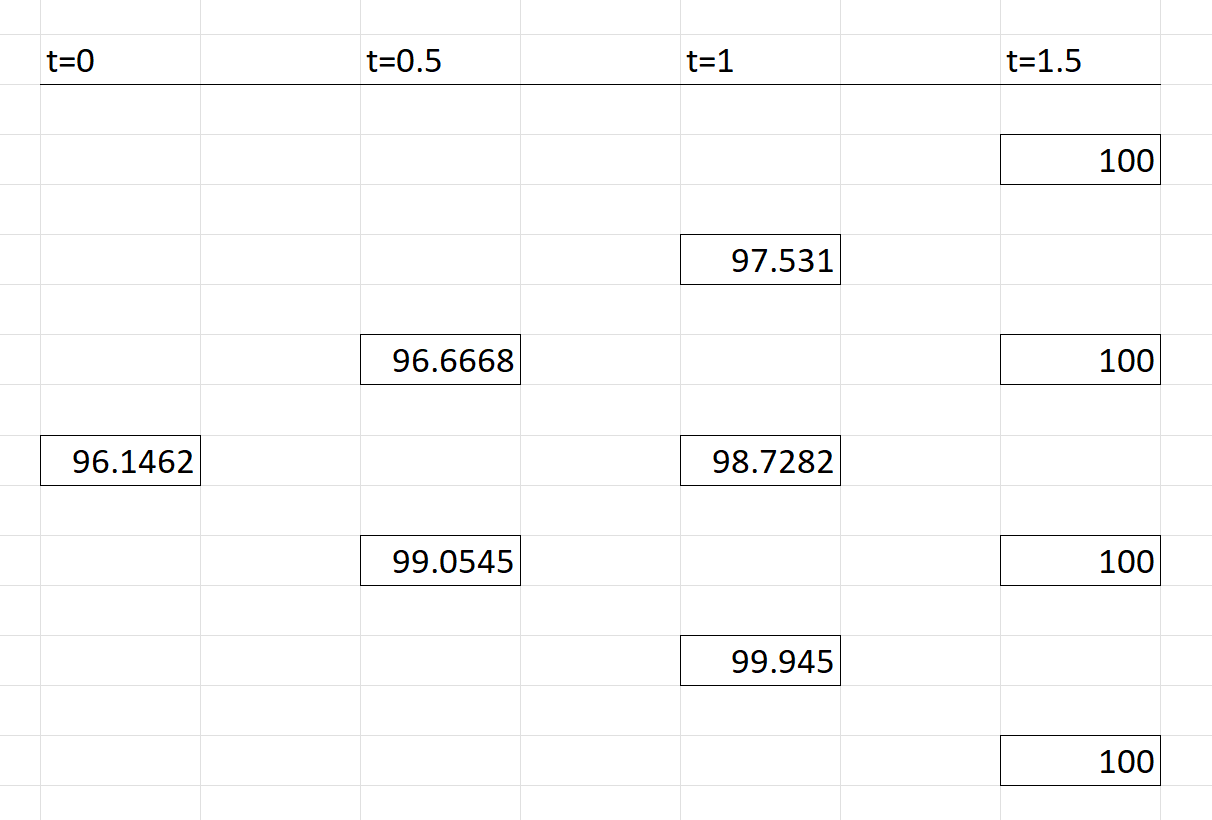

### 4.2
Report the risk-neutral probability of an up movement at $t=1$.

(The risk-neutral probability of an up movement at $t=0.5$ continues to be as you calculated in 2.3.

In [51]:
r1_up = 0.0339
dt = 0.5
A = np.exp(r1_up * dt)
pstar_1 = (P1_u * A - P2_du)/(P2_uu-P2_du)

print(f"The risk neutral probability of an upward movement at t=1|up is: {pstar_1}, or {round(pstar_1 * 100, 2)}%")

## Calculation 2
r1_down = 0.0095
dt = 0.5
A = np.exp(r1_down * dt)
pstar_2 = (P1_d * A - P2_dd)/(P2_du-P2_dd)

print(f"The risk neutral probability of an upward movement at t=1|down is: {pstar_2}, or {round(pstar_2 * 100, 2)}%")

p_up = 0.6449 * pstar_1 + (1-0.6449) * pstar_2
print(f"Hence the risk neutral probability of an upward movement at t=0 is: {p_up}, or {round(p_up * 100, 2)}%")

The risk neutral probability of an upward movement at t=1|up is: 0.34153398040082517, or 34.15%
The risk neutral probability of an upward movement at t=1|down is: 0.34423802446529234, or 34.42%
Hence the risk neutral probability of an upward movement at t=0 is: 0.34249418644811747, or 34.25%


### 4.3
Calculate the price of the European **call** option?
* expiring at $T=1$ 
* written on the bond maturing in 3 periods, ($t=1.5$)

I will assume the strike continues to be $99.00 and use replication to price.

In [54]:
# I will assume the strike continues to be $99

# Start with upper tree
FACE = 100
r1_up = .0339
P2_up = [97.531, 98.7282]
K = 99
fud = [0, 0]

beta = (fud[0] - fud[1]) / (P2_up[0] - P2_up[1])
alpha = (fud[0] - beta * P2_up[0])/FACE

position = pd.DataFrame(index=['2-period bond','3-period bond'],columns=['price','position','$ holding'],dtype=float)
position['price'] = [97.8925, 96.1462]
position['position'] = [alpha,beta]
position['$ holding'] = position['price'] * position['position']
position.loc['net','$ holding'] = position['$ holding'].sum()
# print("position 1:", position)
# Get the price of the upper node of the tree
upper_price = position.iloc[2,2]

# Now price the lower tree
FACE = 100
P2_down = [98.7282, 99.945]
K=99
fud = [ 0, P2_down[1] - K]


beta = (fud[0] - fud[1]) / (P2_down[0] - P2_down[1])
alpha = (fud[0] - beta * P2_down[0])/FACE

position = pd.DataFrame(index=['2-period bond','3-period bond'],columns=['price','position','$ holding'],dtype=float)
position['price'] = [97.8925, 96.1462]
position['position'] = [alpha,beta]
position['$ holding'] = position['price'] * position['position']
position.loc['net','$ holding'] = position['$ holding'].sum()
# print("position 2:", position)

# Get the price of the lower node of the tree
lower_price = position.iloc[2,2]

# Now that we have two prices, and pstar, we can solve for t=0 price using expectation.
pstar = 0.6449 # From Problem 2
C0_price = pstar * upper_price + (1 - pstar) * lower_price
# print(f"The t=0 price of the call expiring at T=1 with a strike of $99.00 = ${round(C0_price, 2)}")


price = 0.3551*(1-0.3442)*(99.945-99)
print(f"The t=0 price of the call expiring at T=1 with a strike of $99.00 = ${round(price, 2)}")

The t=0 price of the call expiring at T=1 with a strike of $99.00 = $0.22


### 4.4
Consider a finer time grid. Let $dt$ in the tree now be 1/30 instead of 0.5.

Using this smaller time step, compute the $t=0$ price of the following option:
* option expires at $t=1$
* written on bond maturing at $t=1.5$

# 5 American Style
### 5.1
Use the two-period tree from part 4, but this time to price an American-style **put** option.

Use a grid of $dt=.5$.
* What is its value at $t=0$?
* Which nodes would you exercise it early?


In [53]:
# I will assume the strike continues to be 2%
# This is the same code as above with the payoff function adjusted for the put payoff

# Start with upper tree
FACE = 100
r1_up = .0339
r2 = np.array([.05, .0256])
rK = .02
fud = FACE * (rK-r2)
fud[fud<0] = 0

P2_up = [97.531, 98.7282]

beta = (fud[0] - fud[1]) / (P2_up[0] - P2_up[1])
alpha = (fud[0] - beta * P2_up[0])/FACE

position = pd.DataFrame(index=['1-period bond','2-period bond'],columns=['price','position','$ holding'],dtype=float)
position['price'] = [97.8925, 96.1462]
position['position'] = [alpha,beta]
position['$ holding'] = position['price'] * position['position']
position.loc['net','$ holding'] = position['$ holding'].sum()

# Get the price of the upper node of the tree
upper_price = position.iloc[2,2]

# Now price the lower tree
FACE = 100
r1_down = .0095
r2 = np.array([.0256, .0011])
rK = .02
fud = FACE * (r2-rK)
fud[fud<0] = 0

P2_down = [98.7282, 99.945]

beta = (fud[0] - fud[1]) / (P2_down[0] - P2_down[1])
alpha = (fud[0] - beta * P2_down[0])/FACE

position = pd.DataFrame(index=['1-period bond','2-period bond'],columns=['price','position','$ holding'],dtype=float)
position['price'] = [97.8925, 96.1462]
position['position'] = [alpha,beta]
position['$ holding'] = position['price'] * position['position']
position.loc['net','$ holding'] = position['$ holding'].sum()

# Get the price of the lower node of the tree
lower_price = position.iloc[2,2]

# Now that we have two prices, and pstar, we can solve for t=0 price using expectation.
pstar = 0.6449 # From Problem 2
C0_price = pstar * upper_price + (1 - pstar) * lower_price
print(f"The t=0 price of the put expiring at T=1 with a strike of 2% = ${round(C0_price, 2)}")

The t=0 price of the put expiring at T=1 with a strike of 2% = $0.28


### 5.2
Change the grid to $dt=1/30$, as in 4.4. 
* What is its value at $t=0$?
* Make a visualization showing which nodes have early exercise. (I suggest using a dataframe and the `heatmap` from `seaborn`.